# CheXpert

### Data Origin
reference: https://stanfordaimi.azurewebsites.net/datasets/23c56a0d-15de-405b-87c8-99c30138950c

Downloaded CheXpert Test and Validation Datasets and CheXLocalize Dataset.

Will repurpose test and validation datasets for training and validation, using cross-validation or another method.

## Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
# change this depending on where the Chexpert folder is in your drive
base_path = 'drive/MyDrive/Stanford Chexpert'
CheXpert_path = f'{base_path}/CheXpert'
CheXlocalize_path = f'{base_path}/CheXlocalize'
groundtruth_path = f'{base_path}/groundtruth.csv'

files = os.listdir(base_path)
print(files)

['CheXlocalize', 'CheXpert', 'groundtruth.csv']


In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy
import plotly.express as px

In [ ]:
# seed data
seed = 10
torch.manual_seed(seed)

### Dataframes

In [ ]:
groundtruth_df = pd.read_csv(groundtruth_path)
print(groundtruth_df.shape)
groundtruth_df

(500, 15)


,Study,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0/test/patient64741/study1,0,1,1,1,0,0,0,0,0,0,0,0,0,1
1,CheXpert-v1.0/test/patient64742/study1,0,1,0,1,0,0,0,0,1,0,0,0,0,0
2,CheXpert-v1.0/test/patient64743/study1,0,1,1,1,0,1,0,0,1,0,0,0,0,0
3,CheXpert-v1.0/test/patient64744/study1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,CheXpert-v1.0/test/patient64745/study1,0,1,1,1,1,0,0,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,CheXpert-v1.0/test/patient65236/study1,0,1,1,1,0,1,0,0,0,0,0,0,0,1
496,CheXpert-v1.0/test/patient65237/study1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
497,CheXpert-v1.0/test/patient65238/study1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
498,CheXpert-v1.0/test/patient65239/study1,0,1,1,1,0,1,0,0,1,0,0,0,0,1


In [ ]:
val_df = pd.read_csv(f'{CheXpert_path}/val_labels.csv')
print(val_df.shape)
# print(val_df.describe())
val_df.head()["Path"][0]

(234, 19)


'CheXpert-v1.0/valid/patient64541/study1/view1_frontal.jpg'

### Path Manipulation

In [ ]:


val_transform_path_col = val_df["Path"]
val_path_df = pd.DataFrame()

val_path_df["view"] = val_transform_path_col.apply(lambda x : os.path.basename(x))
val_path_df["patient"] = val_transform_path_col.apply(lambda x : x.split('/')[2])
# path_df["study"] = transform_path_col.apply(lambda x : x.split('/')[3]) # not unique/doesn't differ


# fig = px.bar(x, x='Path')
# fig.show()
val_path_df

,view,patient
0,view1_frontal.jpg,patient64541
1,view1_frontal.jpg,patient64542
2,view2_lateral.jpg,patient64542
3,view1_frontal.jpg,patient64543
4,view1_frontal.jpg,patient64544
...,...,...
229,view1_frontal.jpg,patient64736
230,view1_frontal.jpg,patient64737
231,view1_frontal.jpg,patient64738
232,view1_frontal.jpg,patient64739


In [ ]:


x = val_path_df.groupby("view")["patient"].count()
print(x)


fig = px.bar(x, x='patient', title="Patient per View Distribution")
fig.show()

view
view1_frontal.jpg    200
view2_frontal.jpg      2
view2_lateral.jpg     29
view3_lateral.jpg      3
Name: patient, dtype: int64


In [ ]:
x = val_path_df.groupby("patient")["view"].count()
print(len(x))

fig = px.bar(x, x='view', title="View per Patient Distribution")
fig.show()

200


In [ ]:
test_df =  pd.read_csv(f'{CheXpert_path}/test_labels.csv')
print(test_df.shape)
test_df

In [ ]:
test_transform_path_col = test_df["Path"]
test_path_df = pd.DataFrame()

test_path_df["view"] = test_transform_path_col.apply(lambda x : os.path.basename(x))
test_path_df["patient"] = test_transform_path_col.apply(lambda x : x.split('/')[2])
x = test_path_df.groupby("view")["patient"].count()
print(x)


fig = px.bar(x, x='patient', title="Patient per View Distribution")
fig.show()

view
view1_frontal.jpg    500
view2_frontal.jpg     18
view2_lateral.jpg    134
view3_lateral.jpg     16
Name: patient, dtype: int64


##### Check Uniqueness of view1_frontal.jpg (check if every patient has a view1_frontal.jpg)

- also alters original DF's

In [ ]:
def transformDF(df):
  """
  mutates df in place, performing necessary feature engineering
  """
  df["View"] = df["Path"].apply(lambda x : os.path.basename(x))
  df["Patient"] = df["Path"].apply(lambda x : x.split('/')[2])
  df.drop(df[df["View"] != "view1_frontal.jpg"].index, inplace=True)


In [ ]:
transformDF(val_df)
val_df

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,...,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,View,Patient
0,CheXpert-v1.0/valid/patient64541/study1/view1_...,Male,73,Frontal,AP,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,view1_frontal.jpg,patient64541
1,CheXpert-v1.0/valid/patient64542/study1/view1_...,Male,70,Frontal,PA,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,view1_frontal.jpg,patient64542
3,CheXpert-v1.0/valid/patient64543/study1/view1_...,Male,85,Frontal,AP,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,view1_frontal.jpg,patient64543
4,CheXpert-v1.0/valid/patient64544/study1/view1_...,Female,42,Frontal,AP,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,view1_frontal.jpg,patient64544
5,CheXpert-v1.0/valid/patient64545/study1/view1_...,Female,55,Frontal,AP,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,view1_frontal.jpg,patient64545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229,CheXpert-v1.0/valid/patient64736/study1/view1_...,Female,57,Frontal,AP,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,view1_frontal.jpg,patient64736
230,CheXpert-v1.0/valid/patient64737/study1/view1_...,Male,65,Frontal,AP,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,view1_frontal.jpg,patient64737
231,CheXpert-v1.0/valid/patient64738/study1/view1_...,Male,71,Frontal,AP,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,view1_frontal.jpg,patient64738
232,CheXpert-v1.0/valid/patient64739/study1/view1_...,Female,45,Frontal,AP,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,view1_frontal.jpg,patient64739


In [ ]:
transformDF(test_df)
print(type(test_df.iloc[0].loc["No Finding"]))

,Path,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,View,Patient
0,test/patient64741/study1/view1_frontal.jpg,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,view1_frontal.jpg,study1
1,test/patient64742/study1/view1_frontal.jpg,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,view1_frontal.jpg,study1
2,test/patient64743/study1/view1_frontal.jpg,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,view1_frontal.jpg,study1
3,test/patient64744/study1/view1_frontal.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,view1_frontal.jpg,study1
6,test/patient64745/study1/view1_frontal.jpg,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,view1_frontal.jpg,study1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
663,test/patient65236/study1/view1_frontal.jpg,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,view1_frontal.jpg,study1
664,test/patient65237/study1/view1_frontal.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,view1_frontal.jpg,study1
665,test/patient65238/study1/view1_frontal.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,view1_frontal.jpg,study1
666,test/patient65239/study1/view1_frontal.jpg,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,view1_frontal.jpg,study1


In [ ]:
# drop other views
# val_df = val_df.drop(val_df[val_df["View"] != "view1_frontal.jpg"].index)
# test_df = test_df.drop(test_df[test_df["View"] != "view1_frontal.jpg"].index)

print(f'{val_df.shape}')  # should be 200
print(f'{test_df.shape}') # should be 500

(200, 21)
(500, 17)


In [ ]:
# TODO: some check to verify that there are N images corresponding to N patients
# maybe just group by patient and count or graph visually like previously?

test_df.iloc[0]

Path                          test/patient64741/study1/view1_frontal.jpg
No Finding                                                           0.0
Enlarged Cardiomediastinum                                           1.0
Cardiomegaly                                                         1.0
Lung Opacity                                                         1.0
Lung Lesion                                                          0.0
Edema                                                                0.0
Consolidation                                                        0.0
Pneumonia                                                            0.0
Atelectasis                                                          0.0
Pneumothorax                                                         0.0
Pleural Effusion                                                     0.0
Pleural Other                                                        0.0
Fracture                                           

### Preparing Images


In [ ]:
files = os.listdir(f'{CheXpert_path}/test')
print(len(files)) # should be 500 w/o DS_store files

500


In [ ]:
files = os.listdir(f'{CheXpert_path}/val')
print(len(files)) # should be 200 w/o DS_store files

200


### Deleting DS_Store files

DS_Store files created from Macbook from local download. Only run if they exist.


In [ ]:
# Remove top level .DS_store
# counts if there are any extranenous files
# os.remove(f'{CheXpert_path}/val/.DS_Store') # change val for test, if needed
counter = 0
for f in files:
  if os.path.exists(f'{CheXpert_path}/test/{f}'):
    counter+=len(os.listdir(f'{CheXpert_path}/test/{f}'))
    # for d in os.listdir(f'{CheXpert_path}/val/{f}'):
      # if d != "study1":
      #   print(d)
print(counter)

# recursively deletes .DS_Store Files
def delete_ds_store_files(root_dir):
    for root, dirs, files in os.walk(root_dir):
        for file in files:
            if file == ".DS_Store":
                file_path = os.path.join(root, file)
                try:
                    os.remove(file_path)
                    print(f"File '{file}' has been deleted.")
                except Exception as e:
                    print(f"An error occurred while deleting '{file}': {e}")

delete_ds_store_files(f'{CheXpert_path}/val') # change val for test, if needed

0


## Create and Load the Dataset
ref: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

In [ ]:
# seed data
seed = 10
torch.manual_seed(seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

In [ ]:
# check if gpu is being used
# use A100 (newer) or V100
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)


# Check if a GPU is available
# assign device to GPU or CPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU is not available, using CPU")

Fri Dec  1 06:46:01 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    24W / 300W |      2MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# functions
def transformDF(df):
  """
  mutates df in place, performing necessary feature engineering
  """
  df["View"] = df["Path"].apply(lambda x : os.path.basename(x))
  df["Patient"] = df["Path"].apply(lambda x : x.split('/')[2])
  df.drop(df[df["View"] != "view1_frontal.jpg"].index, inplace=True)

In [ ]:
from torchvision.io import read_image, ImageReadMode
from torch.utils.data import Dataset
import torchvision.transforms.functional as TF


class CheXpertDataset(Dataset):

  def __init__(self, dataDir: list, transform=None, target_transform=None):
    dfs = []
    for d in dataDir:
      df = pd.read_csv(d)
      dfs.append(df)
    self.df = pd.concat(dfs, ignore_index=True) # must be same shape/same cols
    transformDF(self.df)

    self.labels = ['No Finding',
       'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
       'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
       'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
       'Support Devices']
    self.transform = transform
    self.target_transform = target_transform

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    path = self.df.iloc[idx]["Path"].split("/")[-4:]
    img_path = f'{CheXpert_path}/{"/".join(path)}'
    image = read_image(img_path, mode=ImageReadMode.RGB)
    labels = torch.Tensor(self.df.iloc[idx].loc[self.labels]) # returns whole dataframe (needs to be only the multi-labels and as a Torch Tensor)
    if self.transform:
        image = self.transform(image)
    if self.target_transform:
        label = self.target_transform(label)
    return image, labels



In [ ]:
from torchvision import transforms
import torchvision.transforms.functional as TF
# TODO: create Transforms for both the labels and images
# need to transform images to be same size
# need to convert multilabels to torch tensors
transform = transforms.Compose([
    # transforms.PILToTensor(),
    transforms.Resize((2000, 2000), antialias=True),
    # transforms.Resize((256, 256)),
    # transforms.RandomResizedCrop(256)
])

pretrain_transform = transforms.Compose([
    # transforms.PILToTensor(),
    transforms.Resize((512, 512), antialias=True),
    # transforms.Resize((256, 256)),
    # transforms.RandomResizedCrop(256)
])


# TODO: add random crop and flip transformations to create more data
# ref: https://pieriantraining.com/multilabel-image-classification-in-pytorch-a-guide/
val_dataset = CheXpertDataset([f'{CheXpert_path}/val_labels.csv'], transform=pretrain_transform ) # need a better transform process
# transforms resize does not cut off image (compresses or uncompresses to fit)
# resized to an average size about
test_dataset = CheXpertDataset([f'{CheXpert_path}/test_labels.csv'], transform=pretrain_transform )
combined_dataset = CheXpertDataset([f'{CheXpert_path}/test_labels.csv', f'{CheXpert_path}/val_labels.csv'])
# print(val_dataset.df.shape)
# val_dataset.df

In [ ]:
print(val_dataset.df.shape)
print(test_dataset.df.shape)

(200, 21)
(500, 17)


In [ ]:
labels = ['No Finding',
       'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
       'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
       'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
       'Support Devices']

torch.Tensor(val_dataset.df.iloc[0].loc[labels])

tensor([0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
# initialize dataloaders
train_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True) # 500
test_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True) # 200

# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
# print(f"Feature batch shape: {train_features.size()}")
# print(f"Labels batch shape: {train_labels.size()}")

# sizes: 2320, 2828 / 2001, 1941 / 2308, 2740 / 1631, 2021

for i in range(4):
  print(train_features[i].shape)
  img = train_features[i].squeeze()
  img = img.numpy().transpose((1, 2, 0))
  label = train_labels[i]
  plt.imshow(img)
  plt.show()
  print(f"Label: {label}")

### Vision Transformer Model

In [ ]:
from torchvision.models.vision_transformer import VisionTransformer, ViT_L_16_Weights, vit_l_16
from torchvision import transforms
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader
# could potentially use 512 ViT pretrained


class myViT(nn.Module):

  def __init__(self, architecture, unfreeze_last_layer, pretrained=True, **kwargs):
    super(myViT, self).__init__()
    self.transformer = architecture(ViT_L_16_Weights.IMAGENET1K_SWAG_E2E_V1) if pretrained else VisionTransformer(**kwargs)
    # https://python.plainenglish.io/how-to-freeze-model-weights-in-pytorch-for-transfer-learning-step-by-step-tutorial-a533a58051ef
    if pretrained:
      # freezing weights
      for param in self.transformer.parameters():
        param.requires_grad = False
      # unfreezing weights (of last layer)
      if unfreeze_last_layer:
        for param in self.transformer.heads.parameters():
          param.requires_grad = True


    # self.threshold = 0.5
    self.postprocessing = nn.Sequential(nn.Linear(1000, 14)) # 14 classes)
    # self.sigmoid = nn.Sigmoid()
    # GELU(approximate='none')
    #         (2): Dropout(p=0.0, inplace=False)
    #         (3): Linear(in_features=4096, out_features=1024, bias=True)
    #         (4): Dropout(p=0.0, inplace=False)

  def forward(self, x):

    out = self.transformer(x)
    out = self.postprocessing(out)
    # out = self.sigmoid(out)
    # out = (out > self.threshold).float()
    return out





In [ ]:
# check memory usage

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


## Training

In [ ]:
import torch.optim as optim

# model architecture
model = myViT(vit_l_16, True, pretrained=True)
model.to(device)
# num_epochs = 10
# learning_rate = 0.01
# criterion = nn.functional.binary_cross_entropy_with_logits
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)
model

In [ ]:
# Early Stopping class

class EarlyStopping():
    def __init__(self, patience=5, delta=0, verbose=False, path='checkpoint.pt'):
        """
        Stops the model if improvement is negligible.

        After a certain number of epochs (patience), if the loss doesn't
        improve by (delta) then the model will stop
        training by setting the early_stop flag to True
        and save the model to (path)
        """

        self.patience = patience # how many epochs to wait for improvement
        self.delta = delta # threshold for improvement (if doesn't improve by this much by "n" epochs, stop training)
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [ ]:
def predict(model, criterion, test_dataloader):
    # Predicting 1 epoch
  threshold = 0.5
  y_pred_list = []
  y_target_list = []
  model.eval()

  epoch_val_loss = 0.0

  with torch.no_grad():
    for i, (img, labels) in enumerate(test_dataloader):
      img = img.to(device)
      labels = labels.to(device)
      img = img.float()
      output = model(img)
      loss = criterion(output, labels)
      output = (output > threshold).float()

      y_pred_list.extend(output.detach().tolist())
      y_target_list.extend(labels.detach().tolist())

      epoch_val_loss += loss.item()
    epoch_val_loss /= len(test_dataloader)

  return y_pred_list, y_target_list, epoch_val_loss

In [ ]:
def train_model(Model, input_size, batch_size, num_epochs, learning_rate, path):
  # init Early Stopping
  early_stopping = EarlyStopping(patience=2, delta=0.01, verbose=True, path=path)

  # initialize datasets
  pretrain_transform = transforms.Compose([transforms.Resize((input_size , input_size), antialias=True)])

  val_dataset = CheXpertDataset([f'{CheXpert_path}/val_labels.csv'], transform=pretrain_transform )
  test_dataset = CheXpertDataset([f'{CheXpert_path}/test_labels.csv'], transform=pretrain_transform )
  combined_dataset = CheXpertDataset([f'{CheXpert_path}/test_labels.csv', f'{CheXpert_path}/val_labels.csv'])

  # initialize dataloaders
  train_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True) # 500
  test_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True) # 200

  # model architecture
  model = Model
  criterion = nn.functional.binary_cross_entropy_with_logits
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)


  threshold = 0.5

  train_loss = []
  val_loss = []

  # Train the model
  total_step = len(train_dataloader)
  for epoch in range(num_epochs):
    epoch_train_loss = 0.0
    model.train()
    for i, (img, labels) in enumerate(train_dataloader):
      # print(f"{i}th mini-batch")
      img = img.to(device)
      labels = labels.to(device)
      img = img.float()
      output = model(img)
      loss = criterion(output, labels)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      epoch_train_loss += loss.item()

      if (i+1) % 10 == 0:
          print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
    epoch_train_loss /= len(train_dataloader)
    train_loss.append(epoch_train_loss)

    # predicting step
    _, _, epoch_val_loss = predict(model, criterion, test_dataloader)
    early_stopping(epoch_val_loss, model)

    val_loss.append(epoch_val_loss)
    if early_stopping.early_stop:
        print("Early stopping")
        break

  # final prediction
  predictions, targets, epoch_val_loss = predict(model, criterion, test_dataloader)
  model.train()

  return predictions, targets, model, train_loss, val_loss




In [ ]:
num_epochs = 5
learning_rate = 0.001
input_size = 512
batch_size = 5
y_pred_list, y_target_list, model, train_loss, val_loss = train_model(model, input_size, batch_size, num_epochs, learning_rate, "model.pth")

## Evaluation

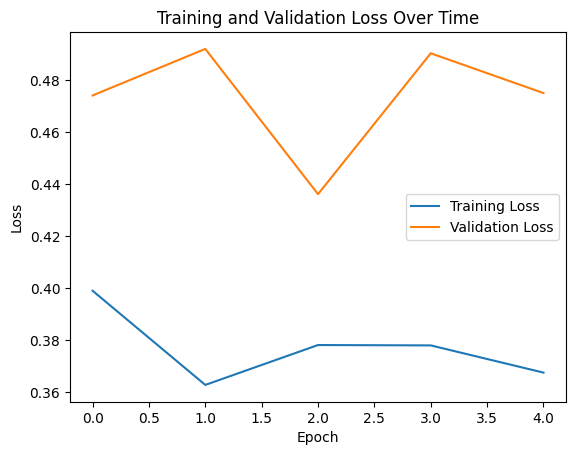

In [ ]:
# Plotting the losses
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.show()

In [ ]:
print(y_pred_list)
print(y_target_list )

[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

In [ ]:
from sklearn.metrics import precision_score, recall_score, multilabel_confusion_matrix, f1_score, ConfusionMatrixDisplay, \
 accuracy_score, roc_auc_score, RocCurveDisplay, balanced_accuracy_score, hamming_loss
ytest_target = y_target_list
ytest_pred = y_pred_list

conf_matrix = multilabel_confusion_matrix(ytest_target ,ytest_pred)
print("Confusion Matrix of the Test Set")
print("-----------")
print("Accuracy of the model :\t"+str(accuracy_score(ytest_target,ytest_pred))) # exact match
# IMPORTANT: Hamming Loss is a good metric for multilabel appararently
print("Hamming Loss of the model :\t"+str(hamming_loss(ytest_target,ytest_pred))) # perfect is 0 for Hamming Loss
print("Precision of the model :\t"+str(precision_score(ytest_target,ytest_pred, average=None)))
print("Recall of the model    :\t"+str(recall_score(ytest_target,ytest_pred, average=None)))
print("F1 Score of the Model :\t"+str(f1_score(ytest_target,ytest_pred, average=None)))
# Stanford CheXpert study uses ROC AUC metric
print("ROC AUC of the Model :\t"+str(roc_auc_score(ytest_target,ytest_pred, average='micro', multi_class="ovr"))) # ovr = one vs rest

# perfect is 1 for all metrics

Confusion Matrix of the Test Set
-----------
Accuracy of the model :	0.035
Hamming Loss of the model :	0.22142857142857142
Precision of the model :	[0.5        0.68181818 0.         1.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Recall of the model    :	[0.11538462 0.28571429 0.         0.04310345 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
F1 Score of the Model :	[0.1875     0.40268456 0.         0.08264463 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
ROC AUC of the Model :	0.5257041777734102


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


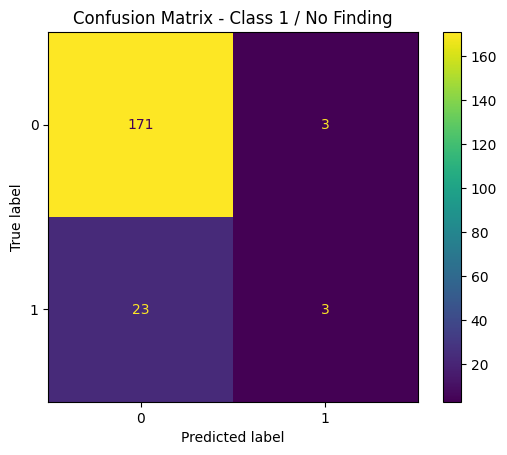

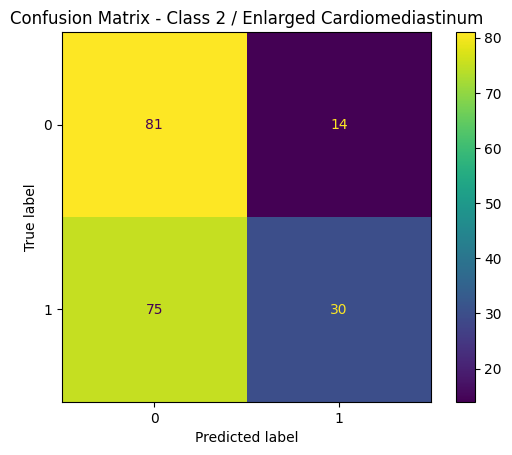

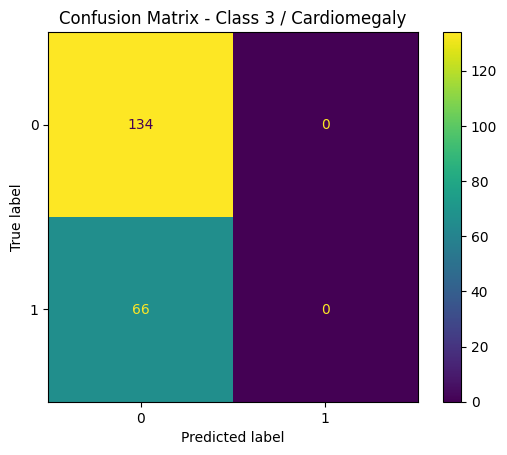

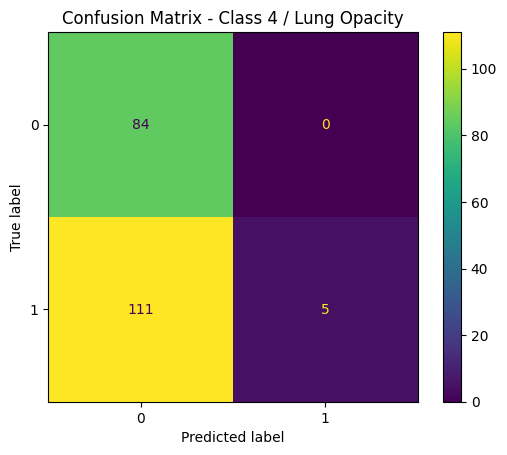

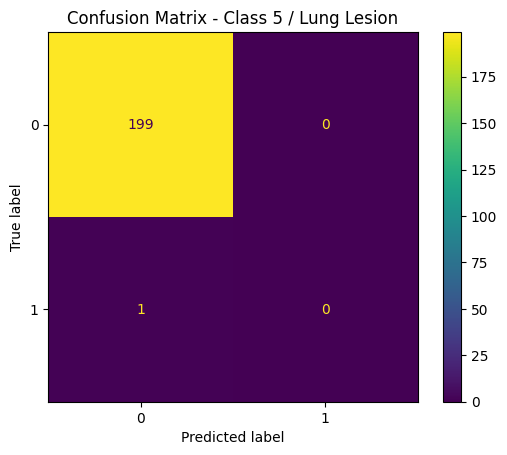

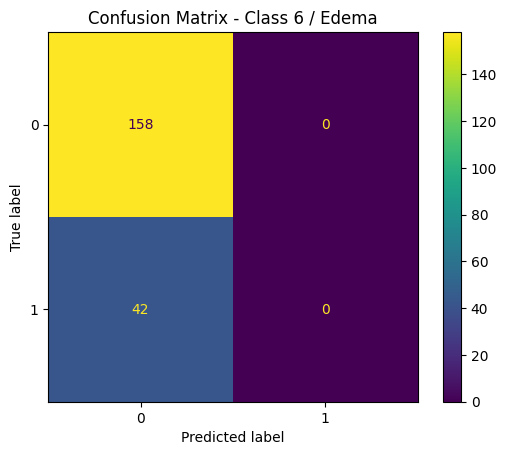

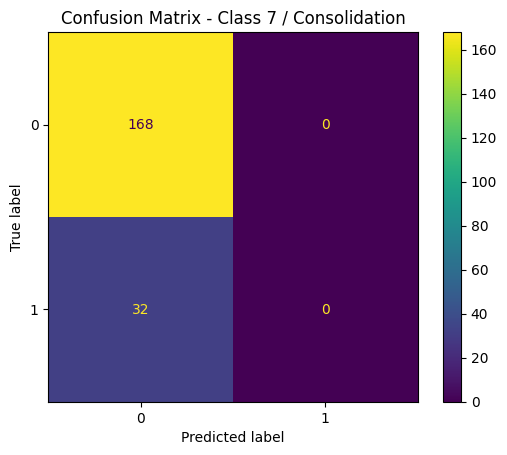

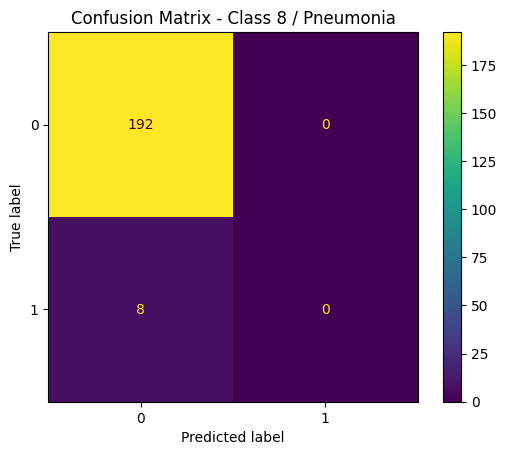

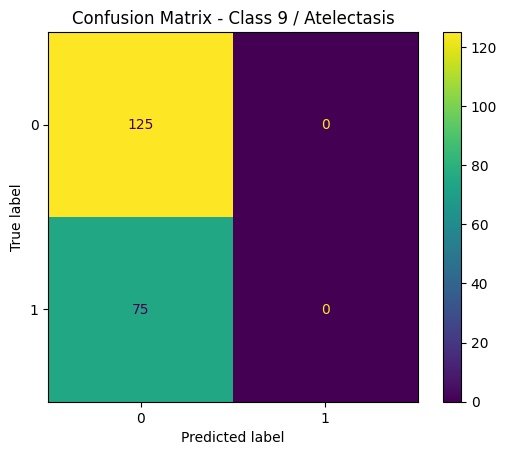

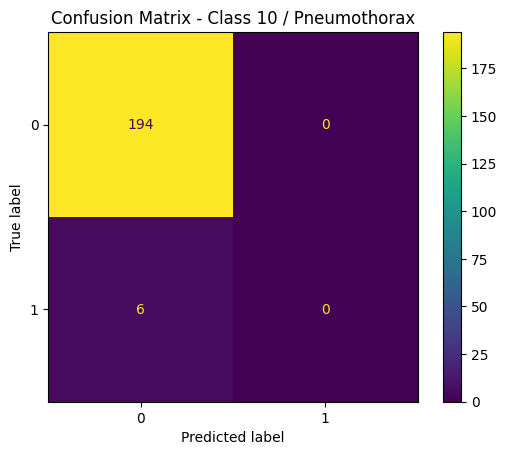

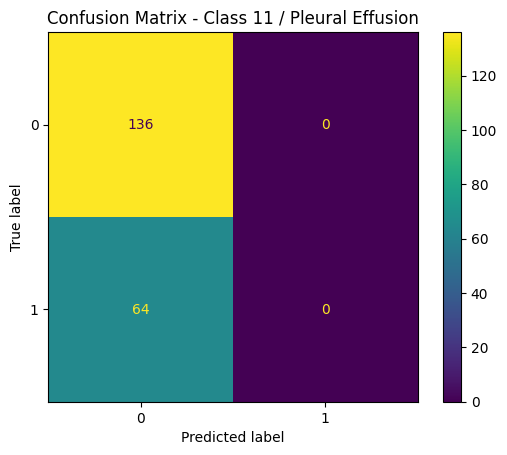

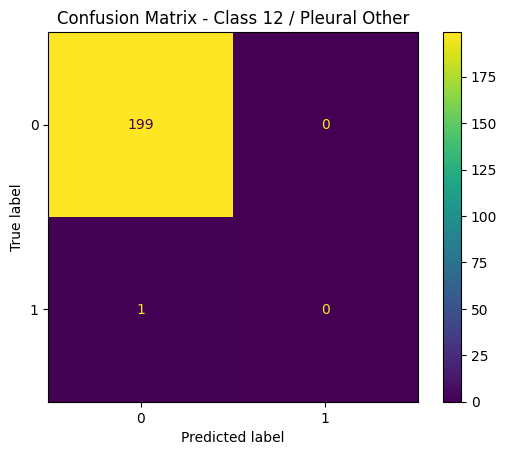

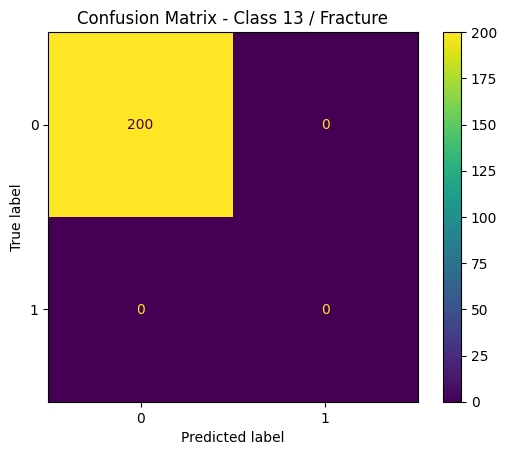

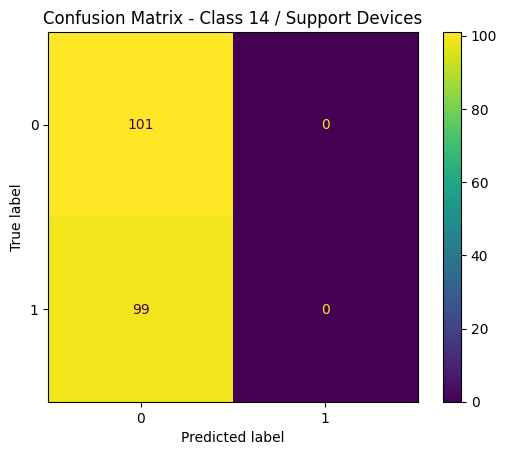

In [ ]:
labels = ['No Finding',
       'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
       'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
       'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
       'Support Devices']
for i, c in enumerate(conf_matrix):
  display = ConfusionMatrixDisplay(confusion_matrix=c).plot() # may change to subplots
  plt.title(f'Confusion Matrix - Class {i + 1} / {labels[i]}')
  plt.show()

In [ ]:
# clear GPU cache

torch.cuda.empty_cache()

# Waterloo Kaggle Dataset

ref: https://www.kaggle.com/datasets/andyczhao/covidx-cxr2



### Setup

In [1]:
from google.colab import drive, files

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy
import plotly.express as px

In [3]:
# seed data
seed = 10
torch.manual_seed(seed)

In [ ]:
# check if gpu is being used
# use A100 (newer) or V100
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)


# Check if a GPU is available
# assign device to GPU or CPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU is not available, using CPU")

In [ ]:
!pip install kaggle
! mkdir ~/.kaggle
# change this to your path to your kaggle.json in your google drive
! cp ./drive/MyDrive/Kaggle/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d andyczhao/covidx-cxr2
! unzip covidx-cxr2.zip

In [ ]:
!unzip covidx-cxr2.zip

In [8]:

def create_df(path):
  df = pd.read_csv(path, delimiter=' ', header=None)
  df.columns = ['Patient ID', 'Filename', 'Class', 'Data Source']
  # with open('train.txt', 'r') as f:
  #     for line in f:
  #         i, j, k, l = line.split()
  #         df = pd.concat([df, pd.DataFrame([{'Patient ID': i, 'Filename': j, 'Class': k, 'Data Source': l}])], ignore_index=True)

  return df






In [9]:
train_df = create_df('train.txt')
test_df = create_df('test.txt')
val_df = create_df('val.txt')

### COVID Dataset classes

In [10]:
from torchvision.io import read_image, ImageReadMode
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF


class WaterlooDataset(Dataset):

  def __init__(self, imgDir: list, target_df, transform=None, target_transform=None):
    self.df = target_df
    self.imgDir = imgDir
    self.transform = transform
    self.target_transform = target_transform

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    path = self.df.iloc[idx]["Filename"]
    img_path = f'{self.imgDir}/{path}'
    image = read_image(img_path, mode=ImageReadMode.RGB)
    label = self.df.iloc[idx]["Class"]
    if label == "positive":
      label = 1
    else:
      label = 0
    if self.transform:
        image = self.transform(image)
    if self.target_transform:
        label = self.target_transform(label)
    return image, float(label)


67863
8482
8473
2121
266
265
torch.Size([3, 224, 224])


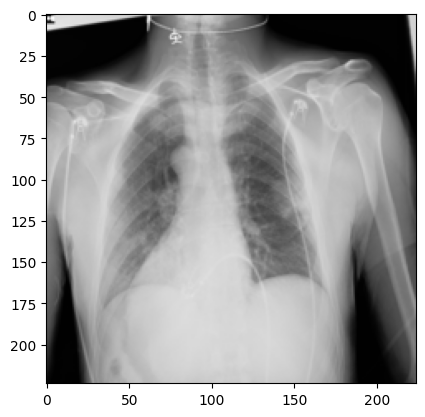

Label: 1.0
torch.Size([3, 224, 224])


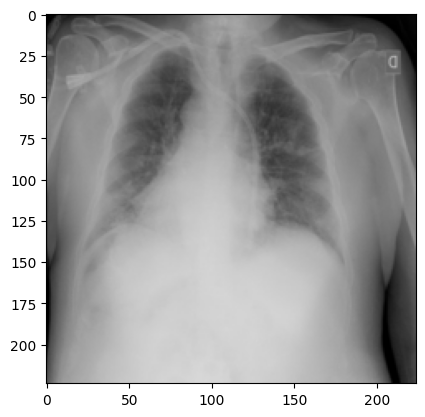

Label: 1.0
torch.Size([3, 224, 224])


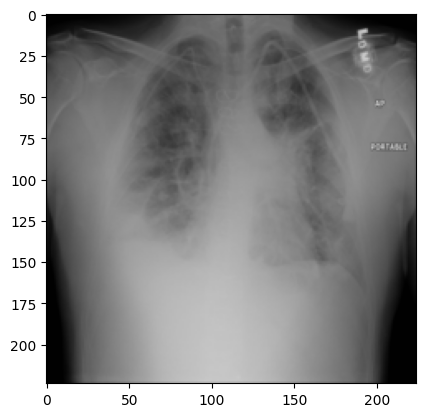

Label: 0.0
torch.Size([3, 224, 224])


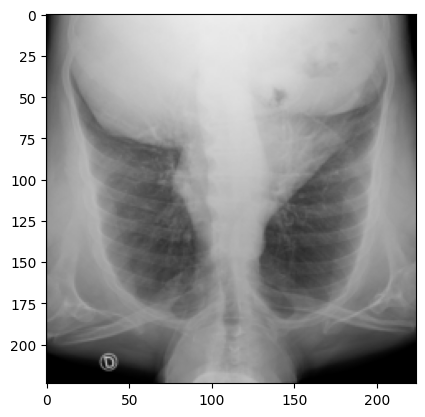

Label: 1.0


In [11]:
# sample the dataset
from torchvision import transforms
transform = transforms.Compose([
    transforms.Resize((224,224), antialias=True),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip()

])

train_dataset = WaterlooDataset("train", train_df,transform=transform)
test_dataset = WaterlooDataset("test", test_df, )
val_dataset = WaterlooDataset("val",val_df,transform=transform)

batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

print(len(train_dataset))
print(len(test_dataset))
print(len(val_dataset))

print(len(train_dataloader))
print(len(test_dataloader ))
print(len(val_dataloader))

train_features, train_labels = next(iter(train_dataloader))

for i in range(4):
  print(train_features[i].shape)
  img = train_features[i].squeeze()
  img = img.numpy().transpose((1, 2, 0))
  label = train_labels[i]
  plt.imshow(img)
  plt.show()
  print(f"Label: {label}")

### Transformer classes

In [18]:
from torchvision.models.vision_transformer import VisionTransformer, ViT_B_16_Weights, vit_b_16, vit_l_16, ViT_L_16_Weights
from torchvision.models.swin_transformer import swin_t, Swin_T_Weights
from torchvision import transforms
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader

import torchvision.models as models

# # Load pretrained ResNet50
# resnet50 = models.resnet50(pretrained=True)
# s = swin_t(weights="DEFAULT")

# could potentially use 512 ViT pretrained


class mySWIN(nn.Module):

  def __init__(self, architecture, unfreeze_last_layer, pretrained=True, **kwargs):
    super(mySWIN, self).__init__()
    self.transformer = architecture(weights="DEFAULT") if pretrained else VisionTransformer(**kwargs)
    # https://python.plainenglish.io/how-to-freeze-model-weights-in-pytorch-for-transfer-learning-step-by-step-tutorial-a533a58051ef
    if pretrained:
      # freezing weights
      for param in self.transformer.parameters():
        param.requires_grad = False
      # unfreezing weights (of last layer)
      if unfreeze_last_layer:
        for param in self.transformer.head.parameters():
          param.requires_grad = True


    # self.threshold = 0.5
    self.postprocessing = nn.Sequential(nn.Linear(1000, 100), nn.Dropout(p=0.2), nn.ReLU(),
                                        nn.Linear(100,10), nn.Dropout(p=0.2), nn.ReLU(),
                                        nn.Linear(10,1)
                                        )
    # self.sigmoid = nn.Sigmoid()
    # GELU(approximate='none')
    #         (2): Dropout(p=0.0, inplace=False)
    #         (3): Linear(in_features=4096, out_features=1024, bias=True)
    #         (4): Dropout(p=0.0, inplace=False)

  def forward(self, x):

    out = self.transformer(x)
    out = self.postprocessing(out)
    # out = self.sigmoid(out)
    # out = (out > self.threshold).float()
    return out

class myViT(nn.Module):

  def __init__(self, architecture, unfreeze_last_layer, pretrained=True, **kwargs):
    super(myViT, self).__init__()
    self.transformer = architecture(ViT_B_16_Weights.DEFAULT) if pretrained else VisionTransformer(**kwargs)
    # https://python.plainenglish.io/how-to-freeze-model-weights-in-pytorch-for-transfer-learning-step-by-step-tutorial-a533a58051ef
    if pretrained:
      # freezing weights
      for param in self.transformer.parameters():
        param.requires_grad = False
      # unfreezing weights (of last layer)
      if unfreeze_last_layer:
        for param in self.transformer.heads.parameters():
          param.requires_grad = True


    # self.threshold = 0.5
    self.postprocessing = nn.Sequential(nn.Linear(1000, 100), nn.Dropout(p=0.2), nn.ReLU(),
                                        nn.Linear(100,10), nn.Dropout(p=0.2), nn.ReLU(),
                                        nn.Linear(10,1)
                                        )
    # self.sigmoid = nn.Sigmoid()
    # GELU(approximate='none')
    #         (2): Dropout(p=0.0, inplace=False)
    #         (3): Linear(in_features=4096, out_features=1024, bias=True)
    #         (4): Dropout(p=0.0, inplace=False)

  def forward(self, x):

    out = self.transformer(x)
    out = self.postprocessing(out)
    # out = self.sigmoid(out)
    # out = (out > self.threshold).float()
    return out



### Train Loop

In [13]:
# Early Stopping class
from sklearn.metrics import accuracy_score
import itertools
class EarlyStopping():
    def __init__(self, patience=5, delta=0, verbose=False, path='checkpoint.pt'):
        """
        Stops the model if improvement is negligible.

        After a certain number of epochs (patience), if the loss doesn't
        improve by (delta) then the model will stop
        training by setting the early_stop flag to True
        and save the model to (path)
        """

        self.patience = patience # how many epochs to wait for improvement
        self.delta = delta # threshold for improvement (if doesn't improve by this much by "n" epochs, stop training)
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

def predict(model, criterion, test_dataloader):
    # Predicting 1 epoch
  threshold = 0.5
  y_pred_list = []
  y_target_list = []
  model.eval()

  epoch_val_loss = 0.0

  with torch.no_grad():
    for i, (img, labels) in enumerate(test_dataloader):
      img = img.float()
      img = img.to(device)
      output = model(img)
      labels = torch.Tensor(labels)
      labels = labels.to(device)
      output = output.squeeze().float()
      labels = labels.squeeze().float()

      loss = criterion(output, labels)
      output = (output > threshold).float()

      # img = img.cpu()
      # labels = labels.cpu()

      y_pred_list.extend(output.detach().tolist())
      y_target_list.extend(labels.detach().tolist())

      epoch_val_loss += loss.item()
    epoch_val_loss /= len(test_dataloader)

  # print(y_pred_list)
  # print(y_target_list)

  # y_pred_list = list(itertools.chain.from_iterable(y_pred_list))
  # y_target_list = list(itertools.chain.from_iterable(y_target_list))

  return y_pred_list, y_target_list, epoch_val_loss, accuracy_score(y_target_list, y_pred_list)

def train_model(Model, num_epochs, learning_rate, path,\
                optimizer, criterion, train_dataloader, test_dataloader):
  # init Early Stopping
  early_stopping = EarlyStopping(patience=5, delta=0.001, verbose=True, path=path)

  # model architecture
  model = Model


  threshold = 0.5

  train_loss = []
  train_acc = []
  val_loss = []
  val_acc = []

  # Train the model
  total_step = len(train_dataloader)
  for epoch in range(num_epochs):
    epoch_train_loss = 0.0
    model.train()

    y_pred_list = []
    y_target_list = []


    for i, (img, labels) in enumerate(train_dataloader):
      # print(f"{i}th mini-batch")
      img = img.float()
      img = img.to(device)
      labels = labels.to(device)
      output = model(img)
      output = output.squeeze().float()
      labels = labels.squeeze().float()
      loss = criterion(output, labels)

      # img = img.cpu()
      # labels = labels.cpu()
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      output = (output > threshold).float()
      y_pred_list.extend(output.detach().tolist())
      y_target_list.extend(labels.detach().tolist())

      epoch_train_loss += loss.item()

      if (i+1) % 50 == 0:
          print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    # torch.save(model.state_dict(), path)
    # train metrics
    # print(y_target_list, y_pred_list)
    train_acc.append(accuracy_score(y_target_list, y_pred_list))
    epoch_train_loss /= i
    train_loss.append(epoch_train_loss)

    # predicting step
    _, _, epoch_val_loss, epoch_val_acc = predict(model, criterion, test_dataloader)
    val_loss.append(epoch_val_loss)
    val_acc.append(epoch_val_acc)

    print(f"Epoch {epoch+1}: Train Loss: {epoch_train_loss}, Val Loss: {epoch_val_loss}")
    early_stopping(epoch_val_loss, model)

    # if early_stopping.early_stop:
    #     print("Early stopping")
    #     break

  # final prediction
  # predictions, targets, epoch_val_loss = predict(model, criterion, test_dataloader)
  model.train()

  return model, train_loss, val_loss, val_acc, train_acc

#### Set up dataloaders and sampler

In [14]:

from torchvision import transforms
input_size = 224
transform = transforms.Compose([
    transforms.Resize((input_size, input_size), antialias=True),
    transforms.RandomHorizontalFlip(),
])
train_dataset = WaterlooDataset("train", train_df,transform=transform)
test_dataset = WaterlooDataset("test", test_df, transform=transform)
val_dataset = WaterlooDataset("val",val_df,transform=transform)

batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

print(len(train_dataset))
print(len(test_dataset))
print(len(val_dataset))

print(len(train_dataloader))
print(len(test_dataloader ))
print(len(val_dataloader))

67863
8482
8473
2121
266
265


In [15]:
import random

def generate_random_numbers(K, n):
    # Check if K is greater than n
    if K > n:
        raise ValueError("K must be less than or equal to n.")

    # Use random.sample to generate K unique random numbers from the range [0, n-1]
    random_numbers = random.sample(range(n), K)

    return random_numbers

# Example usage
K = len(train_dataset) // 5 # Number of random numbers to generate
n = len(train_dataset)  # Upper limit of the range (exclusive)

random_numbers = generate_random_numbers(K, n)
print(len(random_numbers))
print(K)
print(K // batch_size)

13572
13572
424


In [16]:
# create new subset of original dataset


D = 2 # how much to divide the dataset by

trainset = torch.utils.data.Subset(train_dataset, generate_random_numbers(len(train_dataset)//D , len(train_dataset)))
valset = torch.utils.data.Subset(val_dataset, generate_random_numbers(len(val_dataset)//D, len(val_dataset)))
num_of_workers = 8
train_dataloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_of_workers)
val_dataloader = DataLoader(valset, batch_size=batch_size, shuffle=True, num_workers=num_of_workers)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=num_of_workers)

# guarantees pulling from same random subset every epoch
# breakpoint randomly samples new subset every epoch
print(len(train_dataloader))
print(len(val_dataloader))
print(len(test_dataloader))

1061
133
266


In [ ]:
# clear GPU cache (RUN THIS BEFORE EVERY TRAINING RUN)

import torch
import torch.nn as nn

import gc
del model
gc.collect()
with torch.no_grad():
    torch.cuda.empty_cache()

In [ ]:
import torch.optim as optim

# model architecture

# switch this to either mySWIN or myViT, depending on which model you would like to train
model = mySWIN(swin_t, True, pretrained=True)
criterion = nn.functional.binary_cross_entropy_with_logits
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
model.to(device)

num_epochs = 50
breakpoint = len(train_dataloader) // 3 # cut down on the train dataset size

# y_pred_list, y_target_list, epoch_val_loss = predict(model, criterion, val_dataloader)
# print(f"Val loss: {epoch_val_loss}")
model,train_loss, val_loss, val_acc, train_acc = train_model(model,\
                                  num_epochs, learning_rate, "model2.pth",\
                        optimizer, criterion, train_dataloader, val_dataloader)
# IMPORTANT: with breakpoint samples a random subset of train data per epoch, so it is different across epochs
# but with the subset, the same data is used per epoch

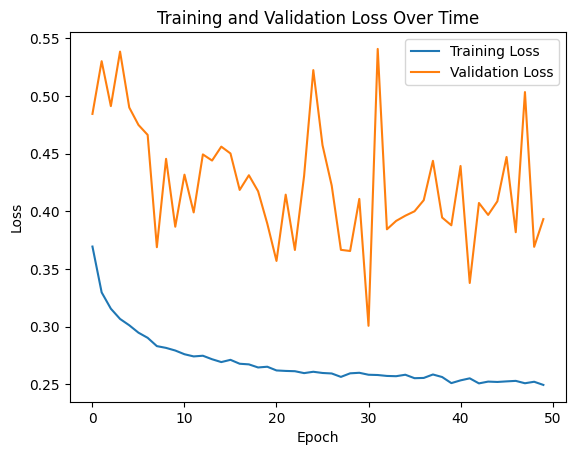

In [19]:
# Plotting the losses
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.show()

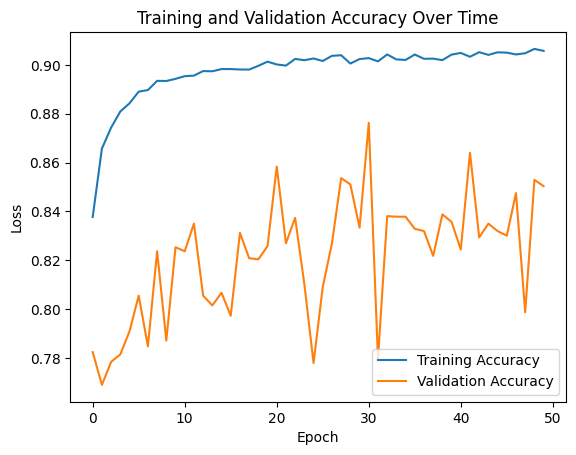

In [20]:
# Plotting the losses
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Accuracy Over Time')
plt.legend()
plt.show()

In [ ]:
# Load the model
# model = torchvision.models.resnet18(pretrained=False)
model =  mySWIN(swin_t, True, pretrained=True)
model.load_state_dict(torch.load('./model2.pth'))
model.to(device)

### Prediction and Evaluation

In [23]:
# Test set prediction

ytest_pred, ytest_target, test_loss, test_acc = predict(model, criterion, val_dataloader)

In [24]:
print(len(ytest_pred), len(ytest_target))
print(ytest_pred[0], ytest_target[0])

4236 4236
0.0 0.0


Confusion Matrix of the Test Set
-----------
[[1711  367]
 [ 149 2009]]
Test Loss of the Model :	0.30086873645397055
Accuracy of the Model :	0.8781869688385269
Precision of the Model :	0.8455387205387206
Recall of the Model    :	0.9309545875810936
F1 Score of the Model :	0.8861932068813411
ROC AUC of the Model :	0.877171230267929


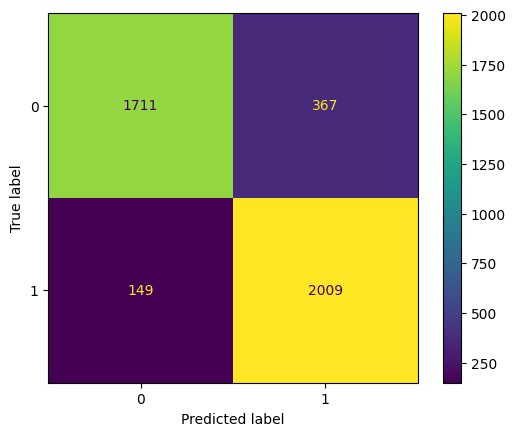

In [25]:
from sklearn.metrics import precision_score, recall_score, multilabel_confusion_matrix, f1_score, ConfusionMatrixDisplay, \
 accuracy_score, roc_auc_score, RocCurveDisplay, balanced_accuracy_score, hamming_loss, confusion_matrix
conf_matrix = confusion_matrix(ytest_target ,ytest_pred)
print("Confusion Matrix of the Test Set")
print("-----------")
print(conf_matrix)
print("Test Loss of the Model :\t"+str(test_loss))
print("Accuracy of the Model :\t"+str(accuracy_score(ytest_target,ytest_pred)))
print("Precision of the Model :\t"+str(precision_score(ytest_target,ytest_pred)))
print("Recall of the Model    :\t"+str(recall_score(ytest_target,ytest_pred)))
print("F1 Score of the Model :\t"+str(f1_score(ytest_target,ytest_pred)))
print("ROC AUC of the Model :\t"+str(roc_auc_score(ytest_target,ytest_pred)))


ConfusionMatrixDisplay(conf_matrix).plot()
plt.show()

## " Transformers Ensemble! "

### Load Transformer models

In [ ]:
model1 = mySWIN(swin_t, True, pretrained=True)
model1.load_state_dict(torch.load('./SWINCOVIDWaterlooDataset.pth'))
model1.to(device)

In [ ]:
model2 = myViT(vit_b_16, True, pretrained=True)
model2.load_state_dict(torch.load('./ViTTransformerWaterLooBest.pth'))
model2.to(device)

In [ ]:
model3 = mySWIN(swin_t, True, pretrained=True)
model3.load_state_dict(torch.load('./Swin2COVID.pth'))
model3.to(device)

### Predict across Transformer models

In [29]:
# can switch out to validation dataloader to predict for validation data
ytest_pred1, ytest_target1, test_loss, test_acc1 = predict(model1, criterion, test_dataloader)
ytest_pred2, ytest_target2, test_loss, test_acc2 = predict(model2, criterion, test_dataloader)
ytest_pred3, ytest_target3, test_loss, test_acc3 = predict(model3, criterion, test_dataloader)

print(f'Accuracy of model 1 {test_acc1}')
print(f'Accuracy of model 2 {test_acc2}')
print(f'Accuracy of model 3 {test_acc3}')

Accuracy of model 1 0.5391417118604103
Accuracy of model 2 0.5445649610940816
Accuracy of model 3 0.5497524168828106


In [30]:
# Take majority vote
predictions = numpy.array(ytest_pred1) + numpy.array(ytest_pred2) + numpy.array(ytest_pred3)
predictions = predictions/3
predictions = (predictions > 0.5).astype(int)
predictions = predictions.astype(float)

### Evaluate Ensemble

Confusion Matrix of Transformer Ensemble for the Test Set
-----------
Test Loss of the Model :	1.3886865668727042
Accuracy of the Model :	0.5080169771280358
Precision of the Model :	0.5040973728609304
Recall of the Model    :	0.9863239801933507
F1 Score of the Model :	0.6671983411755325
ROC AUC of the Model :	0.5080169771280358


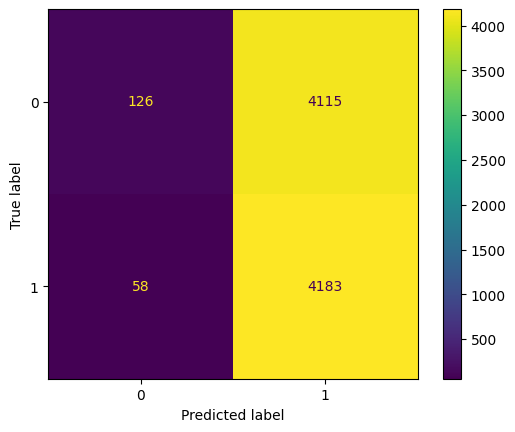

In [31]:
from sklearn.metrics import precision_score, recall_score, multilabel_confusion_matrix, f1_score, ConfusionMatrixDisplay, \
 accuracy_score, roc_auc_score, RocCurveDisplay, balanced_accuracy_score, hamming_loss, confusion_matrix

ytest_target = ytest_target1
ytest_pred = predictions
conf_matrix = confusion_matrix(ytest_target ,ytest_pred)
print("Confusion Matrix of Transformer Ensemble for the Test Set")
print("-----------")
# print(conf_matrix)
print("Test Loss of the Model :\t"+str(test_loss))
print("Accuracy of the Model :\t"+str(accuracy_score(ytest_target,ytest_pred)))
print("Precision of the Model :\t"+str(precision_score(ytest_target,ytest_pred)))
print("Recall of the Model    :\t"+str(recall_score(ytest_target,ytest_pred)))
print("F1 Score of the Model :\t"+str(f1_score(ytest_target,ytest_pred)))
print("ROC AUC of the Model :\t"+str(roc_auc_score(ytest_target,ytest_pred)))


ConfusionMatrixDisplay(conf_matrix).plot()
plt.show()